# Metody analizy danych. Lab 6. Biblioteka pandas, część 3

## 1. Praca z danymi wybrakowanymi (ang. handling missing values)

Dane wybrakowaneto dość częsty przypadek w rzeczywistym świecie. Przyczyna ich obecności może być różna, np. błędy urządzeń pomiarowych, transmisji danych, kodowania znaków, błędnego zapisu lub dopuszczanie wartości typu `null` w danych źródłowych np. w bazie danych.

Istnieje kilka najczęstszych sposobów ich obsługi:

1. **Pozbycie się rekordów (obserwacji)**, które zawierają dane brakujące (w przypadku pandas ora numpy chodzi o wartości reprezentowane przez typ `nan`). To podejście może się sprawdzić, jeżeli mamy dużą próbę danych, a wartości brakujące stanowią ich niewielką część (zazwyczaj nie przekraczającą 5% ogólnej liczby rekordów).
2. **Zastąpienie wartości brakujących** inną wartością:
* arbitralnie wybraną, np. 0 lub np. 'BRAK' co może być traktowane jako dodatkowa wartość cechy,
* średnią dla kolumny,
* modą - wartością najczęściej występującą w kolumnie (dane kategoryczne),
* średnią, modą dla klasy decyzyjnej (dane dla problemu klasyfikacji),
* poprzednią niepustą (w przód lub w tył),
* interpolowaną - tu istnieją różne funkcje (liniowe, kwadratowe, regresja i inne.), które będą określały wartość cechy brakującej na podstawie innych cech niepustych (patrz: https://pandas.pydata.org/docs/reference/api/pandas.Series.interpolate.html#pandas.Series.interpolate),
* z obserwacji najbardziej podobnych.

> Dokumentacja w bibliotece pandas: https://pandas.pydata.org/docs/user_guide/missing_data.html#working-with-missing-data

Techniczny proces obsługi wartości brakujących wydaje się dość prosty, ale faktycznie wymaga zrozumienia jaki wpływ na dane takie działanie będzie miało. Ważne jest aby ze statystycznego punktu widzenia zaburzyć dane w jak najmniejszym stopniu. Należy więc poznać rozkład danych przed i po operacji obsługi wartości brakujących, aby móc tę zmianę ocenić.

In [ ]:
!pip install scipy

## 1.1 Detekcja wartości brakujących

In [64]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
DATAPATH = './data/'

In [6]:
df = pd.read_csv(r'https://raw.githubusercontent.com/YBI-Foundation/Dataset/refs/heads/main/Diabetes%20Missing%20Data.csv')

In [7]:
df.head()

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [8]:
# dzięki funkcji info również możemy się dowiedzieć ile wartości noo-null znajduje się w każdej serii danych
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pregnant           768 non-null    int64  
 1   Glucose            763 non-null    float64
 2   Diastolic_BP       733 non-null    float64
 3   Skin_Fold          541 non-null    float64
 4   Serum_Insulin      394 non-null    float64
 5   BMI                757 non-null    float64
 6   Diabetes_Pedigree  768 non-null    float64
 7   Age                768 non-null    int64  
 8   Class              768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


In [9]:
# funkcje isna() oraz notna() pozwalają sprawdzić czy ramka danych zawiera dane brakujące
# wartość None również jest traktowana jako taka wartość
# Te funkcje zwracają wartości True lub False, a po wyliczeniu sumy dowiemy się ile tych wartości
# w każdej serii jest.
# Ramka zawiera dane wybrakowane w 5 kolumnach, a ich liczebność wygląda następująco.
df.isna().sum()

Pregnant               0
Glucose                5
Diastolic_BP          35
Skin_Fold            227
Serum_Insulin        374
BMI                   11
Diabetes_Pedigree      0
Age                    0
Class                  0
dtype: int64

In [10]:
# dobrze jest również wiedzieć jaki procent względem całości stanowią wartości brakujące
df.isna().sum() / df.shape[0]

Pregnant             0.000000
Glucose              0.006510
Diastolic_BP         0.045573
Skin_Fold            0.295573
Serum_Insulin        0.486979
BMI                  0.014323
Diabetes_Pedigree    0.000000
Age                  0.000000
Class                0.000000
dtype: float64

In [15]:
# przyjmuje się, że próg istotny statystycznie to 5% (w różnych rozważaniach), więc możemy przyjąć, że
# serie danych, które będą posiadały więcej niż 5% wartości brakujących wymagają szczególnej uwagi i usunięcie
# tych danych może nie być dobrym pomysłem z punktu widzenia jakości ewentualnego modelu, który za pomocą 
# tych danych chcemy stworzyć

# W naszym przypadku 3 spośród 5 kolumn zawierających wartości brakujące znajduje się poniżej lub na granicy tego progu, więc
# 2 cechy wymagają więcej uwagi.
# Możemy oczywiście je wskazać w bardziej jednoznaczny sposób.
display((df.isna().sum() / df.shape[0]) > 0.05)
df.columns[(df.isna().sum() / df.shape[0]) > 0.05]

Pregnant             False
Glucose              False
Diastolic_BP         False
Skin_Fold             True
Serum_Insulin         True
BMI                  False
Diabetes_Pedigree    False
Age                  False
Class                False
dtype: bool

Index(['Skin_Fold', 'Serum_Insulin'], dtype='object')

## 1.2 Usuwanie wartości brakujących

Usuwanie wartości brakujących możemy wykonać wykorzystując wbudowaną funkcję `dropna()`:
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna

In [22]:
# uruchomienie dropna() z domyślną wartością atrybutów, co powoduje usunięcie wiersza, który zawiera co najmniej jedną
# brakującą wartość
df_dropped_1 = df.dropna()
df_dropped_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 3 to 765
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pregnant           392 non-null    int64  
 1   Glucose            392 non-null    float64
 2   Diastolic_BP       392 non-null    float64
 3   Skin_Fold          392 non-null    float64
 4   Serum_Insulin      392 non-null    float64
 5   BMI                392 non-null    float64
 6   Diabetes_Pedigree  392 non-null    float64
 7   Age                392 non-null    int64  
 8   Class              392 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 30.6 KB


In [23]:
df_dropped_1.isna().sum()

Pregnant             0
Glucose              0
Diastolic_BP         0
Skin_Fold            0
Serum_Insulin        0
BMI                  0
Diabetes_Pedigree    0
Age                  0
Class                0
dtype: int64

In [24]:
df_dropped_1.head(10)

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
13,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1
14,5,166.0,72.0,19.0,175.0,25.8,0.587,51,1
16,0,118.0,84.0,47.0,230.0,45.8,0.551,31,1
18,1,103.0,30.0,38.0,83.0,43.3,0.183,33,0
19,1,115.0,70.0,30.0,96.0,34.6,0.529,32,1
20,3,126.0,88.0,41.0,235.0,39.3,0.704,27,0


In [32]:
# stworzymy listę cech, które w oryginalnych danych zawierają wartości brakujące
missing_columns = df.columns[(df.isna().sum() / df.shape[0]) > 0].values.tolist()
missing_columns

['Glucose', 'Diastolic_BP', 'Skin_Fold', 'Serum_Insulin', 'BMI']

In [96]:
# wyświetlenie histogramów dla każdej cechy, która zawiera wartości brakujące
bins = 20

# opakujemy kod generujący wykresy w funkcję

def compare_distributions(df_1, df_2, bins=10):
    # iterujemy przez cechy do porównania
    for feature in df_1.columns:
        
        # generujemy dwa histogramy na jednym wykresie
        df_1[feature].hist(bins=bins, figsize=(6, 4), alpha=0.3, density=True, color='g')
        df_1[feature].plot.density(color='g')
        df_2[feature].hist(bins=bins, figsize=(6, 4), alpha=0.3, density=True, color='r')
        df_2[feature].plot.density(color='r')
        plt.title(feature)
        plt.show()

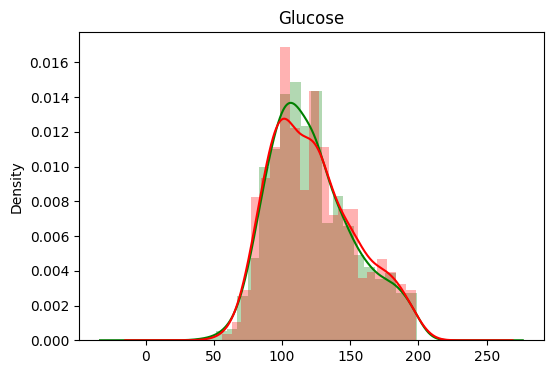

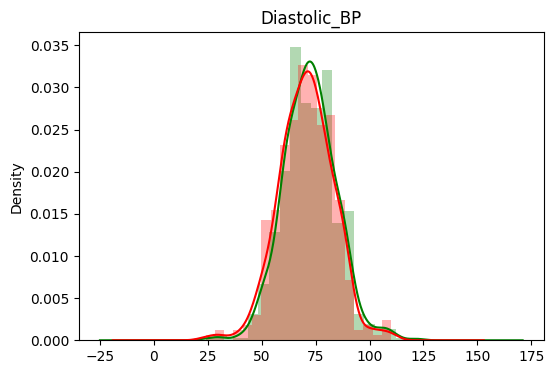

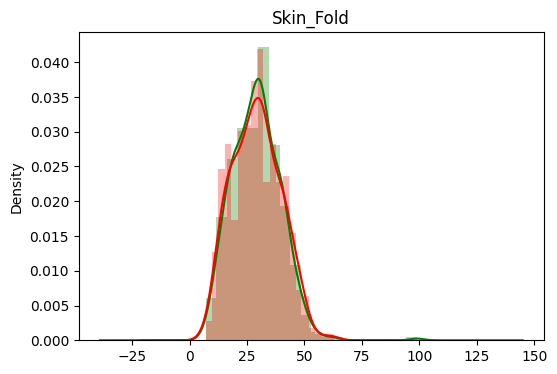

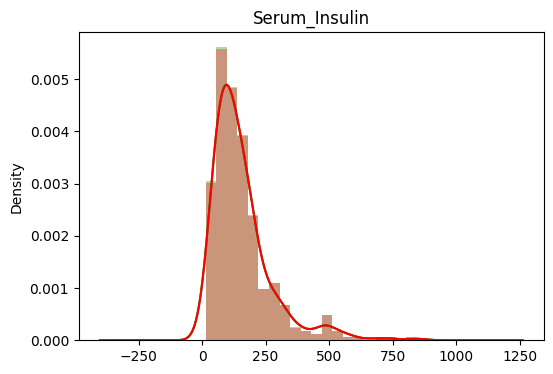

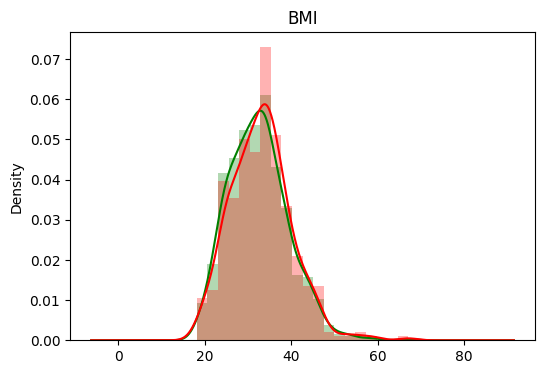

In [97]:
compare_distributions(df[missing_columns], df_dropped_1[missing_columns], bins)

Widać na wykresach powyżej zmiany rozkładów dla większości cech, ale zazwyczaj nie są one bardzo znaczące. Zobaczmy jak inne zmiany będą wpływały na zmiany rozkładu oryginalnych danych.

## 1.3 Zastępowanie wartości brakujących

In [36]:
# Skoro wszystkie cechy są cechami numerycznymi to w pierwszym przykładzie zastąpmy je zerami
df_filled_0 = df.fillna(0)
df_filled_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pregnant           768 non-null    int64  
 1   Glucose            768 non-null    float64
 2   Diastolic_BP       768 non-null    float64
 3   Skin_Fold          768 non-null    float64
 4   Serum_Insulin      768 non-null    float64
 5   BMI                768 non-null    float64
 6   Diabetes_Pedigree  768 non-null    float64
 7   Age                768 non-null    int64  
 8   Class              768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


In [63]:
# widać, że taka operacja wprowadza znaczące zmiany w rozkładzie danych co znacznie je zaburza
# dodatkowo bez znajomości dziedziny zapewne okaże się, że wstawienie wartości 0 dla wybranych
# cech jest wartościa, która w rzeczywistych pomiarach nigdy nie wystąpi! Tu na pewno możemy to
# stwierdzić dla wszystkich z wymienionych cech. Oczywiście widać to na histogramie, ale jak sprawdzimy
# ile wartości 0 występuje w oryginalnych danych w wybranych kolumnach to zobaczymy:
display((df == 0).sum())
# lub tylko dla wybranych kolumn
(df[missing_columns] == 0.0).sum()

Pregnant             111
Glucose                0
Diastolic_BP           0
Skin_Fold              0
Serum_Insulin          0
BMI                    0
Diabetes_Pedigree      0
Age                    0
Class                500
dtype: int64

Glucose          0
Diastolic_BP     0
Skin_Fold        0
Serum_Insulin    0
BMI              0
dtype: int64

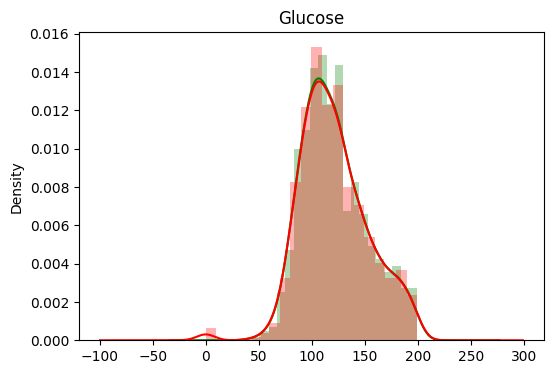

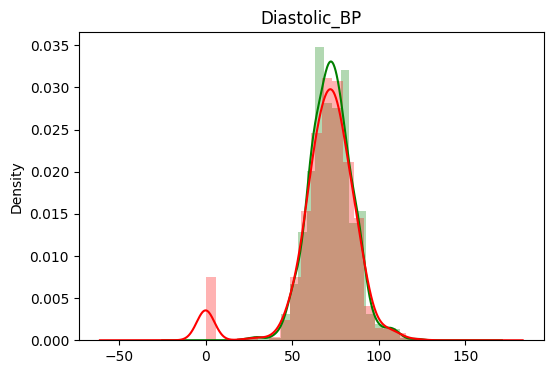

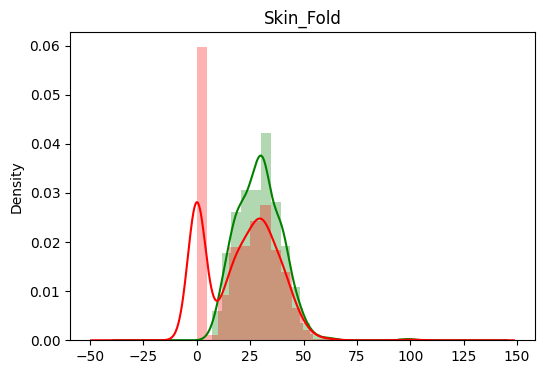

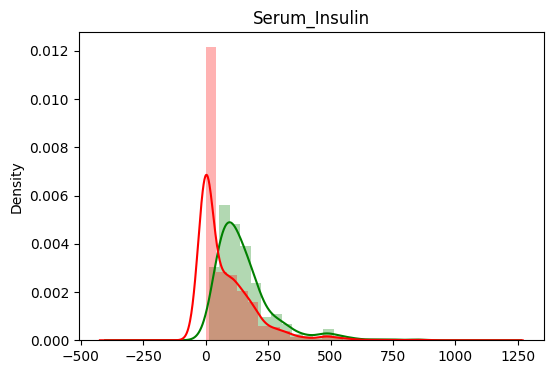

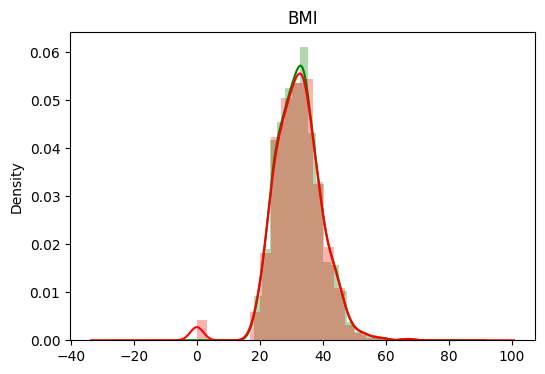

In [98]:
# ponownie porównajmy wykresy
compare_distributions(df[missing_columns], df_filled_0[missing_columns], bins)

Tutaj widać już znaczne zaburzenie danych. Zobaczmy inne możliwości.

In [100]:
# wypełnienie danych wartością średnią (dane numeryczne)
df_filled_mean = df.fillna(df.mean())
df_filled_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pregnant           768 non-null    int64  
 1   Glucose            768 non-null    float64
 2   Diastolic_BP       768 non-null    float64
 3   Skin_Fold          768 non-null    float64
 4   Serum_Insulin      768 non-null    float64
 5   BMI                768 non-null    float64
 6   Diabetes_Pedigree  768 non-null    float64
 7   Age                768 non-null    int64  
 8   Class              768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


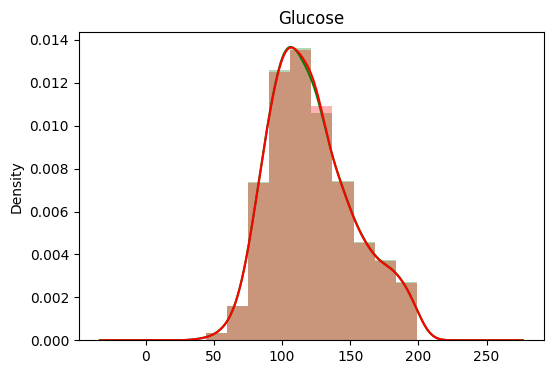

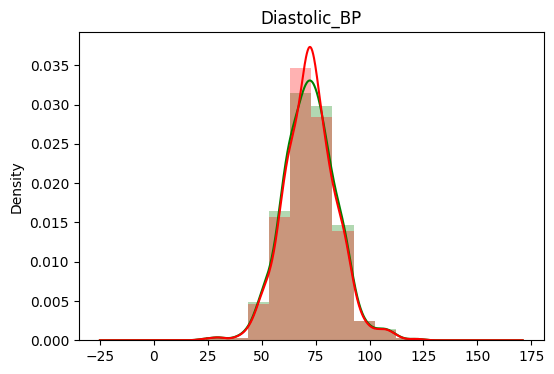

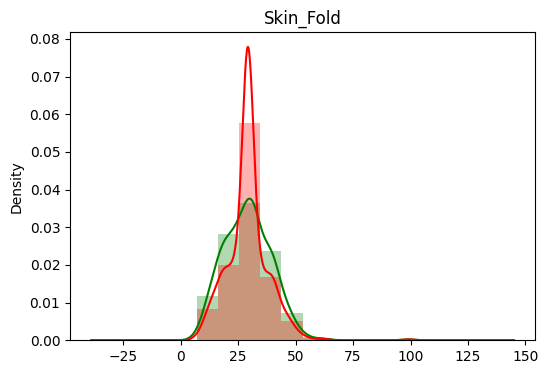

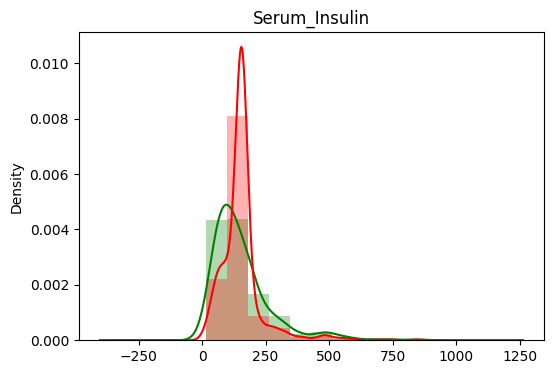

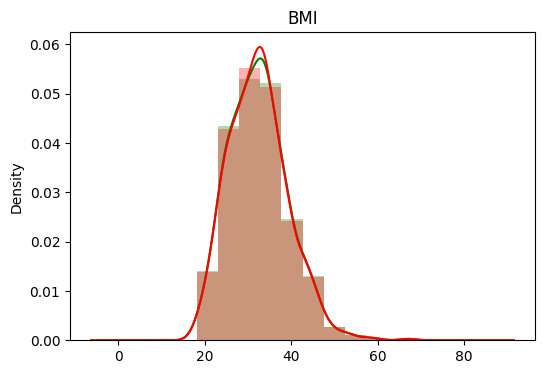

In [104]:
compare_distributions(df[missing_columns], df_filled_mean[missing_columns])

Naturalnie przy takiej zmianie rozkład będzie jeszcze bardziej skupiony wokół wartości średniej rozkładu oryginalnego.

In [112]:
# wypełnienie wartościami w przód lub w tył - oznacza wastawienie wartości poprzedniej dla wartości pustej patrząc
# od początku ramki/serii lub od jej końca
# sprawdźmy to dla cechy, która zawiera najwięcej wartości pustych
df['Serum_Insulin'].head(10),df['Serum_Insulin'].describe()

(0      NaN
 1      NaN
 2      NaN
 3     94.0
 4    168.0
 5      NaN
 6     88.0
 7      NaN
 8    543.0
 9      NaN
 Name: Serum_Insulin, dtype: float64,
 count    394.000000
 mean     155.548223
 std      118.775855
 min       14.000000
 25%       76.250000
 50%      125.000000
 75%      190.000000
 max      846.000000
 Name: Serum_Insulin, dtype: float64)

In [115]:
# wypełnienie wartością w przód
df['Serum_Insulin'].ffill()

0        NaN
1        NaN
2        NaN
3       94.0
4      168.0
       ...  
763    180.0
764    180.0
765    112.0
766    112.0
767    112.0
Name: Serum_Insulin, Length: 768, dtype: float64

In [116]:
# jak widać nie rozwiązuje to problemu, gdy pierwsza wartość (w zależności od kierunku) jest wartością brakującą
# dodajmy więc jeszcze uzupełnienie w tył
df_f_and_b_fill  = df.ffill().bfill()

In [117]:
df_f_and_b_fill.isna().sum()

Pregnant             0
Glucose              0
Diastolic_BP         0
Skin_Fold            0
Serum_Insulin        0
BMI                  0
Diabetes_Pedigree    0
Age                  0
Class                0
dtype: int64

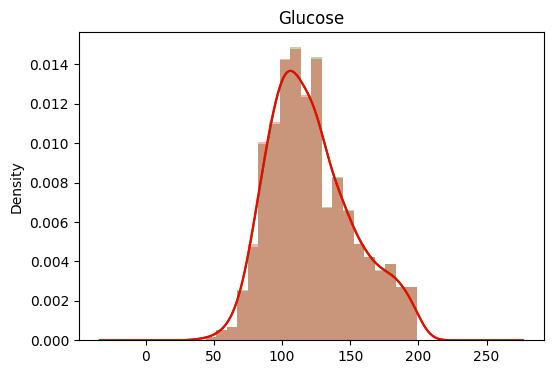

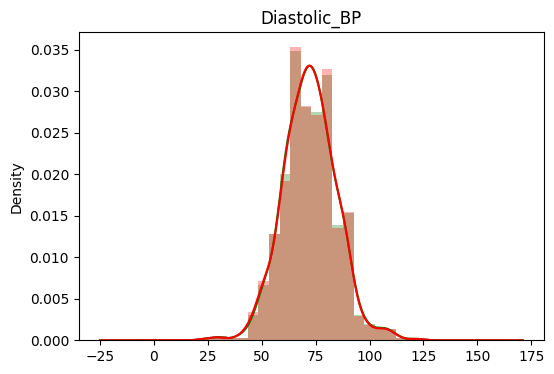

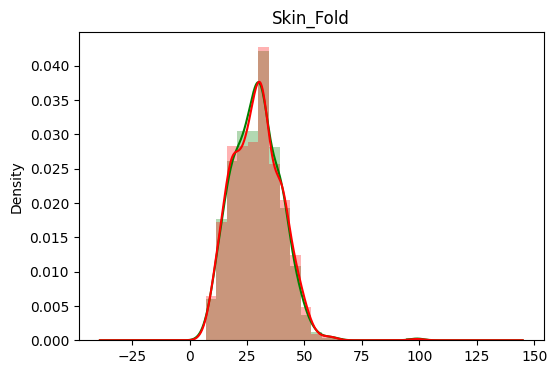

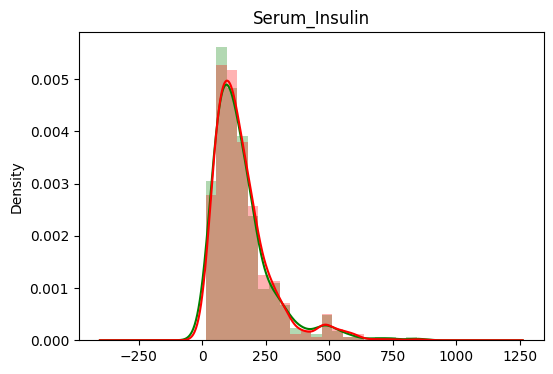

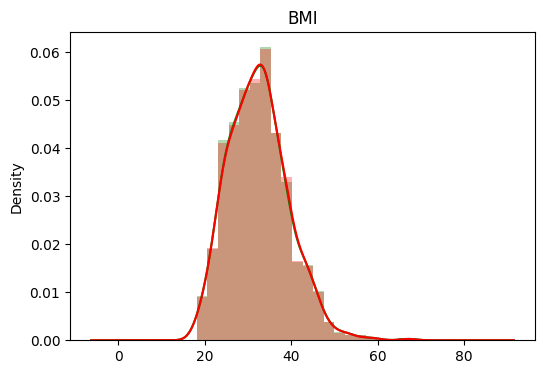

In [118]:
# te operacje były skuteczne, rzućmy okiem na rozkłady
compare_distributions(df[missing_columns], df_f_and_b_fill[missing_columns], bins)

Zmiany w rozkładzie są niewielkie.

**Zobaczmy teraz możliwości funkjci `interpolate()`.**

<Axes: >

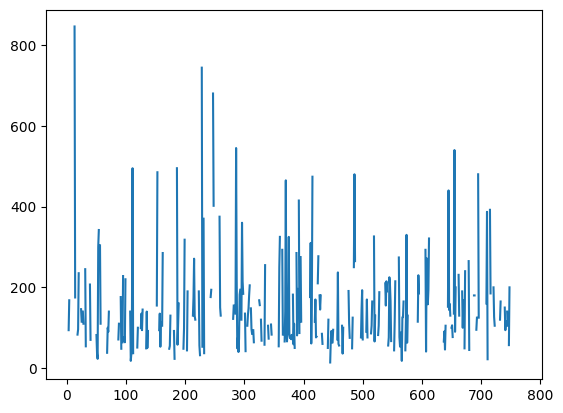

In [120]:
# wykres jest dość poszatkowany ze względu na wartości brakujące
df['Serum_Insulin'].plot()

<Axes: >

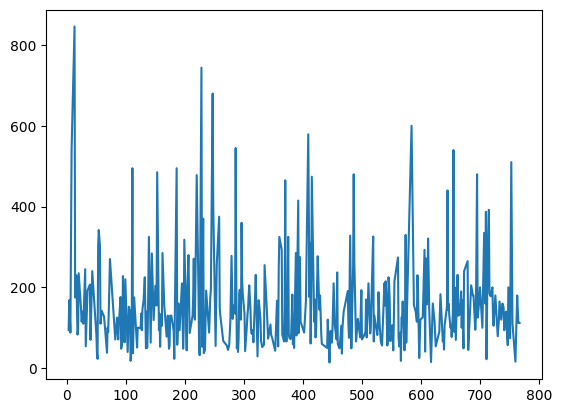

In [122]:
df['Serum_Insulin'].interpolate(method='values').plot()

In [123]:
# jak przyglądniemy się danym, czyli sprawdzimy czy wszystkie wartości brakujące zostały zastąpione to okaże się, że nie
df['Serum_Insulin'].interpolate(method='values').isna().sum()

np.int64(3)

In [124]:
# funkcja interpolacji przyjmuje również argument limit_direction, którego domyślna wartość to forward
# możliwe jest określenie kierunku wstecz lub w obu (odpowiednio backward oraz both)
df['Serum_Insulin'].interpolate(method='values', limit_direction='both').isna().sum()

np.int64(0)

In [125]:
# zobaczmy teraz efek działania dla wszystkich cech
df_interpolate = df.interpolate(method='values', limit_direction='both')

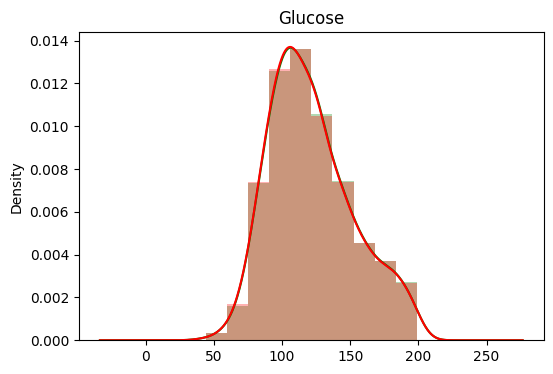

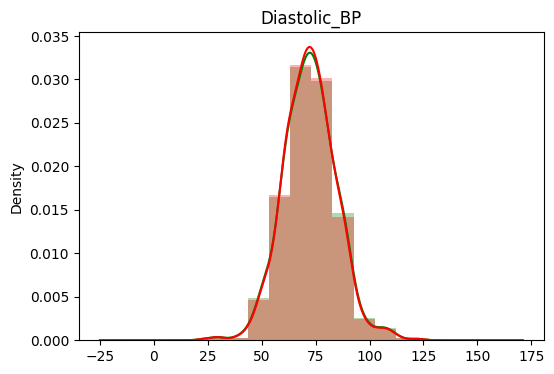

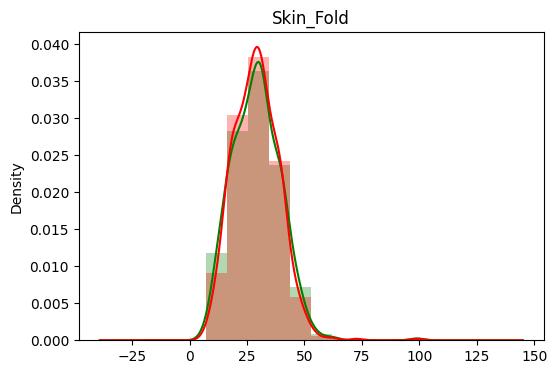

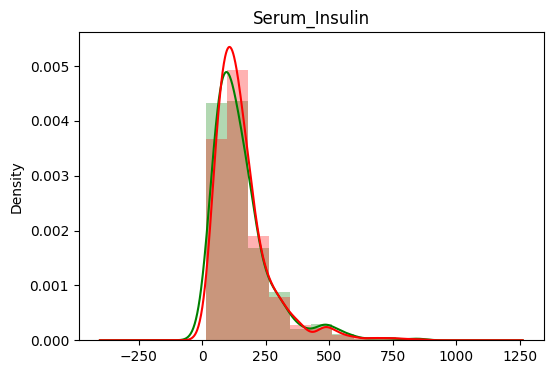

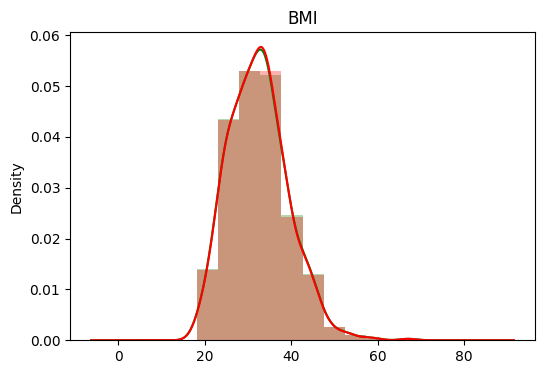

In [126]:
compare_distributions(df[missing_columns], df_interpolate[missing_columns])

Jak widać, efek jest również dobry z punktu widzenia skali zaburzeń oryginalnego rozkładu danych.

## 2. Grupowanie i agregacja danych

Dokumentacja:

* pandas group by: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html

In [92]:
df_zam = pd.read_csv(os.path.join(DATAPATH,'zamowienia.csv'), sep=';')

In [7]:
df_zam.head()

,Kraj,Sprzedawca,Data zamowienia,idZamowienia,Utarg
0,Polska,Kowalski,2003-07-16,10248,440.00
1,Polska,Sowiński,2003-07-10,10249,1863.40
2,Niemcy,Peacock,2003-07-12,10250,1552.60
3,Niemcy,Leverling,2003-07-15,10251,654.06
4,Niemcy,Peacock,2003-07-11,10252,3597.90


In [8]:
# grupowanie danych po kolumnie Kraj i zliczenie ilości wystąpień w każdej grupie
# patrząc na sygnaturę funkcji, pierwszy argument to argument o nazwie by
df_zam.groupby('Kraj').count()

,Sprzedawca,Data zamowienia,idZamowienia,Utarg
Kraj,,,,
Niemcy,584,584,584,584
Polska,215,215,215,215


In [19]:
# ta sama operacja, ale zapisana w inny sposób, który pozwala na określenie wybranych
# kolumn i agregacji dla każdnej z nich z osobna
df_zam.groupby(['Kraj']).agg({'Kraj':['count']})
# to samo co
df_zam.groupby(by=['Kraj']).agg({'Kraj':['count']})

,Kraj
,count
Kraj,
Niemcy,584
Polska,215


In [20]:
# grupowanie po kraju, następnie sprzedawcy, a następnie zliczenie liczby zamówień i sumy dla
# każdego elementu w grupie
df_zam.groupby(['Kraj', 'Sprzedawca']).agg({'idZamowienia':['count'], 'Utarg': ['sum']})

idZamowienia      Utarg
                         count        sum
Kraj   Sprzedawca                        
Niemcy Callahan             99  123032.67
       Davolio             117  182500.09
       Fuller               92  162503.78
       Leverling           125  201196.27
       Peacock             151  225763.68
Polska Dudek                41   75048.04
       King                 67  116962.99
       Kowalski             42   68792.25
       Sowiński             65   72527.63

Dane, które są grupowane poprzez użycie biblioteki pandas zapisywane są w obiekcie typu `pandas.api.typing.DataFrameGroupBy` lub `pandas.api.typing.SeriesGroupBy`. Możemy więc zapisać zgrupowaną ramkę lub serię danych do oddzielnej zmiennej i później w oddzielnych operacjach wyliczać różne agregacje. 

W oficjalnej dokumentacji można znaleźć wszystkie operacje obsługiwane na takich typach danych:

* https://pandas.pydata.org/docs/reference/groupby.html


In [21]:
df_zam_grouped = df_zam.groupby(['Kraj', 'Sprzedawca'])

In [22]:
df_zam_grouped

In [23]:
# wyświetlenie danych dal każdej grupy
df_zam_grouped.groups

{('Niemcy', 'Callahan'): [14, 20, 28, 30, 31, 38, 39, 42, 53, 57, 62, 70, 86, 106, 118, 121, 132, 135, 151, 154, 160, 164, 168, 173, 187, 189, 195, 202, 204, 207, 208, 212, 219, 224, 228, 233, 240, 243, 250, 273, 285, 286, 295, 297, 312, 317, 323, 341, 348, 354, 355, 362, 366, 375, 379, 383, 384, 387, 403, 412, 431, 446, 448, 458, 471, 472, 474, 476, 481, 508, 522, 538, 547, 563, 576, 596, 597, 604, 609, 614, 635, 639, 684, 692, 707, 709, 713, 714, 729, 731, 738, 739, 749, 750, 759, 783, 785, 792, 797], ('Niemcy', 'Davolio'): [10, 22, 27, 37, 44, 45, 56, 58, 63, 66, 68, 77, 92, 103, 109, 113, 116, 123, 126, 128, 129, 137, 139, 145, 146, 148, 152, 153, 157, 205, 213, 217, 221, 225, 234, 238, 260, 276, 277, 289, 294, 298, 310, 314, 319, 331, 339, 343, 350, 356, 357, 364, 368, 370, 378, 382, 405, 407, 416, 417, 420, 423, 429, 432, 441, 442, 461, 462, 465, 469, 470, 485, 495, 498, 525, 528, 537, 540, 541, 544, 552, 565, 573, 577, 579, 586, 587, 594, 602, 611, 629, 638, 640, 646, 652, 654, 

In [25]:
df_zam_grouped.groups.keys()

dict_keys([('Niemcy', 'Callahan'), ('Niemcy', 'Davolio'), ('Niemcy', 'Fuller'), ('Niemcy', 'Leverling'), ('Niemcy', 'Peacock'), ('Polska', 'Dudek'), ('Polska', 'King'), ('Polska', 'Kowalski'), ('Polska', 'Sowiński')])

In [29]:
df_zam_grouped.count()

Data zamowienia  idZamowienia  Utarg
Kraj   Sprzedawca                                      
Niemcy Callahan                 99            99     99
       Davolio                 117           117    117
       Fuller                   92            92     92
       Leverling               125           125    125
       Peacock                 151           151    151
Polska Dudek                    41            41     41
       King                     67            67     67
       Kowalski                 42            42     42
       Sowiński                 65            65     65

In [34]:
# agregacja danych jak w przykładach wcześniejszych, tutaj dodano również sortowanie danych
# po kolumnie zagregowanej, używając multindeksu (w postaci krotki), domyślnie rosnąco
df_zam_grouped.agg({'Utarg': ['sum', 'mean']}).sort_values([('Utarg','sum')])

Utarg             
                         sum         mean
Kraj   Sprzedawca                        
Polska Kowalski     68792.25  1637.910714
       Sowiński     72527.63  1115.809692
       Dudek        75048.04  1830.440000
       King        116962.99  1745.716269
Niemcy Callahan    123032.67  1242.754242
       Fuller      162503.78  1766.345435
       Davolio     182500.09  1559.829829
       Leverling   201196.27  1609.570160
       Peacock     225763.68  1495.123709

In [37]:
# i sortowanie w porządku malejącym
df_zam_grouped.agg({'Utarg': ['sum', 'mean']}).sort_values([('Utarg','sum')], ascending=False)

Utarg             
                         sum         mean
Kraj   Sprzedawca                        
Niemcy Peacock     225763.68  1495.123709
       Leverling   201196.27  1609.570160
       Davolio     182500.09  1559.829829
       Fuller      162503.78  1766.345435
       Callahan    123032.67  1242.754242
Polska King        116962.99  1745.716269
       Dudek        75048.04  1830.440000
       Sowiński     72527.63  1115.809692
       Kowalski     68792.25  1637.910714

In [50]:
# zwracamy n-tą najmniejszą lub największą wartość - te funkcje dostępne są tylko dla typu SeriesGroupBy
df_zam_grouped.agg({'Utarg': ['sum', 'mean']})[('Utarg','sum')].nlargest(3)

Kraj    Sprzedawca
Niemcy  Peacock       225763.68
        Leverling     201196.27
        Davolio       182500.09
Name: (Utarg, sum), dtype: float64

In [53]:
df_zam_grouped['idZamowienia'].count().nsmallest(3)

Kraj    Sprzedawca
Polska  Dudek         41
        Kowalski      42
        Sowiński      65
Name: idZamowienia, dtype: int64

## 4. Zadania

**Zadanie 1**

Dla zbioru danych `zamowienia.csv` wykonaj:
* 1.1 Wczytaj dane i sprawdź czy są w nim jakieś wartości brakujące.
* 1.2 W kolumnie `Sprzedawca` zastąp losowo 10% wartości wartością 'BRAK'. (zobacz funkje pseudolosowe w bibliotece pandas lub numpy oraz wykorzystaj ćwiczenia z zajęć poprzednich z indeksowanie danych w ramkach/seriach)
* 1.3 W kolumnie `idZamowienia` zastąp 5% wartości wartością `np.nan`.
* 1.4 W kolumnie `Data zamówienia` zastąp 20% wartości wartością `np.nan`.
* 1.5 W kolumnie `Utarg` zastąp 15% wartości wartością `np.nan`.
* 1.6 Zbiór z wartościami brakującymi zapisz w oddzielnej zmiennej.

**Zadanie 2**

Dla nowego zbioru (z wartościami brakującymi) z zadania 1 wykonaj:
* 2.1 Zastąp wartości brakujące w kolumnie `idZamowienia` wartością 0.
* 2.2 Zastąp wartości brakujące w kolumnie `Data zamówienia` wartościami w przód (ffill()).
* 2.3 Zastąp wartości brakujące w kolumnie `Utarg` wartością średnią dla danego kraju.

**Zadanie 3**

Wyświetl na wykresach typu histogram wraz z funkcją rozkładu (dokładnie tak jak w przykładach powyżej) rozkłady cechy `Utarg` dla zbioru oryginalnego oraz tego po wykonaniu poleceń z zadania 2.

**Zadanie 4**  

Bazując na przykładach z punktu 2 na zbiorze `zamowienia.csv` policz:

* 4.1 Średnią wartość zamówienia dla każdego kraju.
* 4.2 Średnią wartość zamówienia dla każdego roku, a następnie miesiąca (grupowanie dwustopniowe).\
* 4.3 Liczbę zamówień, którą złożył każdy sprzedawca w danym roku.
* 4.4 Nazwę sprzedawcy z każdego kraju, którego sumaryczny utarg był najwyższy.
* 4.5 Sumę utargu w każdym kwartale (uwzględnij również rok), i posortuj od wartości najwyższych.